In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import matplotlib.pyplot as plt
import requests

#from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [114]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_'+domain+'/'

run_date = '2021-10-27'

In [115]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
calpath = '/nfs/attic/dfh/Aragon2/CSOcal/'+domain+'/'
# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

##path to CSO domain json
#with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
#    domains = json.load(f)

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [116]:
domains[domain]

{'name': 'WY',
 'Bbox': {'latmax': 44.58248,
  'latmin': 42.363116,
  'lonmax': -109.477849,
  'lonmin': -111.155208},
 'st': '2011-09-01',
 'ed': '2016-09-30',
 'stn_proj': 'epsg:4326',
 'mod_proj': 'epsg:32612',
 'ncols': '1382',
 'nrows': '2476',
 'xll': '487200',
 'yll': '4690100',
 'cellsize': '100'}

In [117]:
gdf = gpd.read_file(outpath+'CSO_SNOTEL_sites_'+domain+'.geojson')
df = pd.read_csv(outpath+'SNOTEL_'+domain+'_SWEDmeters'+st+'_'+ed+'.csv') 
gdf.head()

code   longitude   latitude              name        elevation_m  \
0  314_WY_SNTL -110.445442  43.940189         Base Camp  2151.887939453125   
1  347_MT_SNTL -111.128029  44.508320        Black Bear  2490.216064453125   
2  350_WY_SNTL -109.793327  44.376671        Blackwater  2980.944091796875   
3  353_WY_SNTL -110.609734  42.964001    Blind Bull Sum   2636.52001953125   
4  419_WY_SNTL -110.814819  42.645901  Cottonwood Creek   2337.81591796875   

         easting      northing                     geometry  
0  544505.845453  4.865379e+06  POINT (-110.44544 43.94019)  
1  489823.440274  4.928341e+06  POINT (-111.12803 44.50832)  
2  596129.923439  4.914418e+06  POINT (-109.79333 44.37667)  
3  531828.554679  4.756891e+06  POINT (-110.60973 42.96400)  
4  515180.157295  4.721511e+06  POINT (-110.81482 42.64590)

In [118]:
data = xr.open_dataset(calpath+'calibration_'+run_date+'_full_set.nc')
data

<xarray.Dataset>
Dimensions:          (calibration_run: 9720, metric: 5, station: 29)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 4 ... 9716 9717 9718 9719
  * metric           (metric) object 'R2' 'MBE' 'RMSE' 'NSE' 'KGE'
  * station          (station) object '314_WY_SNTL' ... '868_WY_SNTL'
Data variables:
    cal_metrics      (calibration_run, metric, station) float64 ...
Attributes:
    description:             SnowModel line calibration performance metrics
    calibration_parameters:  ro_snowmax,cf_precip_scalar,ro_adjust
    model_parameter:         SWE [m]

In [119]:
swes = xr.open_dataset(calpath+'swe_'+run_date+'_full_set.nc')
swes

<xarray.Dataset>
Dimensions:          (calibration_run: 9720, sim_day: 1857, station: 29)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 4 ... 9716 9717 9718 9719
  * sim_day          (sim_day) int64 0 1 2 3 4 5 ... 1852 1853 1854 1855 1856
  * station          (station) object '314_WY_SNTL' ... '868_WY_SNTL'
Data variables:
    cal_metrics      (calibration_run, sim_day, station) float64 ...
Attributes:
    description:      SnowModel swe
    model_parameter:  SWE [m]

In [120]:
#'cal_params_2020-07-03_full_set.csv'
calibration = pd.read_csv(calpath+'cal_params_'+run_date+'_full_set.csv')
calibration.head()

gap_frac  ro_snowmax  cf_precip_scalar  ro_adjust  conifer_lai
0       0.0       350.0               0.6        4.0          1.8
1       0.0       350.0               0.6        4.0          2.0
2       0.0       350.0               0.6        4.0          2.2
3       0.0       350.0               0.6        4.0          2.4
4       0.0       350.0               0.6        4.0          2.6

In [121]:
# # sidebar to find top performance metrics across domains with pr cf = 1
# cf1data = data.sel(calibration_run=calibration.index[calibration.cf_precip_scalar==1])

# NSE = cf1data.cal_metrics.loc[:,"NSE",:]
# nse_top = np.amax(cf1data.cal_metrics.loc[:,"NSE",:],axis = 0)
# KGE = cf1data.cal_metrics.loc[:,"KGE",:]
# kge_top = np.amax(cf1data.cal_metrics.loc[:,"KGE",:],axis = 0)
# RMSE = cf1data.cal_metrics.loc[:,"RMSE",:]
# rmse_top = np.amin(cf1data.cal_metrics.loc[:,"RMSE",:],axis = 0)
# R_2 = cf1data.cal_metrics.loc[:,"R2",:]
# r2_top = np.amax(cf1data.cal_metrics.loc[:,"R2",:],axis = 0)
# MBE = cf1data.cal_metrics.loc[:,"MBE",:]
# mbe_top = np.amin(cf1data.cal_metrics.loc[:,"MBE",:],axis = 0)
# print(nse_top)

# x = np.empty((len(cf1data.calibration_run),5))
# x[:,0] = np.mean(NSE.values,axis=1)
# x[:,1] = np.mean(KGE,axis=1).values
# x[:,2] = np.mean(RMSE,axis=1).values
# x[:,3] = np.mean(R_2,axis=1).values
# x[:,4] = np.mean(MBE,axis=1).values

# dataav = pd.DataFrame(x,columns=['NSE', 'KGE', 'RMSE','R_2','MBE'])

# def get_top_idx(metric):
#     if (metric == 'R_2') | (metric == 'NSE')|(metric == 'KGE'):
#         x = dataav[metric].values
#         index = np.where(x==np.max(x))
#     elif (metric == 'MBE'):
#         x = np.abs(dataav['MBE']).values
#         index = np.where(x==np.min(x))
#     elif (metric == 'RMSE'):
#         x = dataav[metric]
#         index = np.where(x==np.min(x))
#     return index[0][0]


# top_params = []

# top_params.append(get_top_idx('R_2'))
# top_params.append(get_top_idx('MBE'))
# top_params.append(get_top_idx('RMSE'))
# top_params.append(get_top_idx('NSE'))
# top_params.append(get_top_idx('KGE'))

# print(domain)
# cal_subset = calibration[calibration.cf_precip_scalar==1]
# topav = cal_subset.iloc[top_params]
# topav = topav.reset_index(drop=True)
# topav

<xarray.DataArray 'cal_metrics' (station: 29)>
array([0.83042236, 0.48938295, 0.8262046 , 0.72604855, 0.05826758,
       0.94675767, 0.87969659, 0.91946328, 0.8986635 , 0.50736957,
       0.41886328, 0.81981005, 0.7236706 , 0.82339288, 0.91164314,
       0.89353404, 0.86825746, 0.89906481, 0.84523249, 0.86503191,
       0.73423778, 0.487178  , 0.95482602, 0.87436977, 0.6908672 ,
       0.80532266, 0.38333868, 0.90405496, 0.11314838])
Coordinates:
    metric   <U3 'NSE'
  * station  (station) object '314_WY_SNTL' '347_MT_SNTL' ... '868_WY_SNTL'
WY


gap_frac  ro_snowmax  cf_precip_scalar  ro_adjust  conifer_lai
0       0.0       450.0               1.0        4.0          2.0
1       0.0       700.0               1.0        4.0          1.8
2       0.0       500.0               1.0        6.0          2.0
3       0.0       450.0               1.0        4.0          2.0
4       0.0       500.0               1.0        6.0          1.8

# Find average top performing metrics 
For a given OF, take the average skill score across all stations

In [9]:
NSE = data.cal_metrics.loc[:,"NSE",:]
nse_top = np.amax(data.cal_metrics.loc[:,"NSE",:],axis = 0)
KGE = data.cal_metrics.loc[:,"KGE",:]
kge_top = np.amax(data.cal_metrics.loc[:,"KGE",:],axis = 0)
RMSE = data.cal_metrics.loc[:,"RMSE",:]
rmse_top = np.amin(data.cal_metrics.loc[:,"RMSE",:],axis = 0)
R_2 = data.cal_metrics.loc[:,"R2",:]
r2_top = np.amax(data.cal_metrics.loc[:,"R2",:],axis = 0)
MBE = data.cal_metrics.loc[:,"MBE",:]
mbe_top = np.amin(data.cal_metrics.loc[:,"MBE",:],axis = 0)

print('maxNSE:', r2_top)

maxNSE: <xarray.DataArray 'cal_metrics' (station: 29)>
array([0.8824348 , 0.89942017, 0.94261985, 0.9300761 , 0.75051848,
       0.94751863, 0.8929446 , 0.91946328, 0.95478596, 0.87331523,
       0.84831665, 0.95016788, 0.915955  , 0.92843211, 0.91572349,
       0.96581059, 0.93138059, 0.89906481, 0.93671862, 0.89204601,
       0.73423778, 0.85765819, 0.95482602, 0.92786526, 0.89721149,
       0.91303538, 0.80203528, 0.92463545, 0.71522423])
Coordinates:
    metric   <U2 'R2'
  * station  (station) object '314_WY_SNTL' '347_MT_SNTL' ... '868_WY_SNTL'


Text(0.5, 1.0, 'R**2')

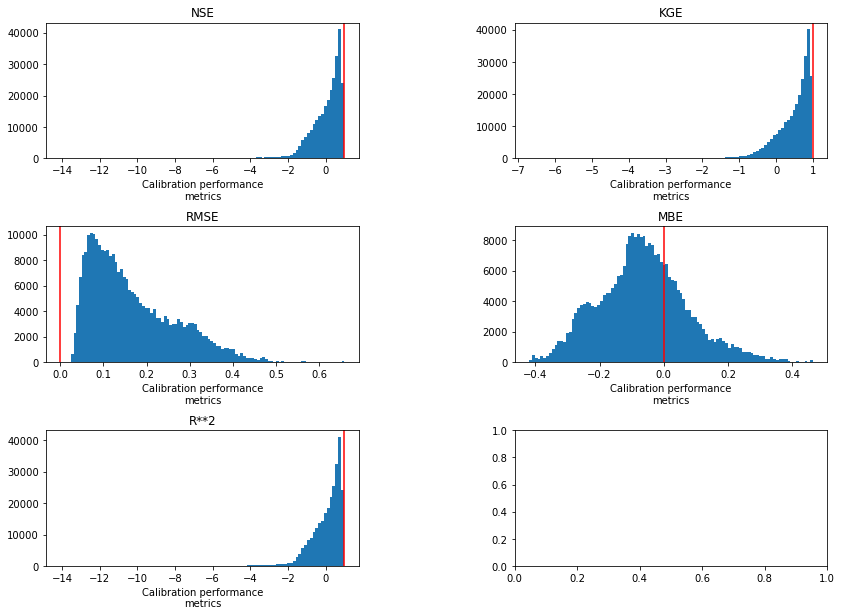

In [10]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axes[0,0].axvline(1,c='r') 
NSE.plot.hist(ax=axes[0,0],bins=100)
axes[0,0].set_title('NSE')
axes[0,1].axvline(1,c='r') 
KGE.plot.hist(ax=axes[0,1],bins=100)
axes[0,1].set_title('KGE')
axes[1,0].axvline(0,c='r') 
RMSE.plot.hist(ax=axes[1,0],bins=100)
axes[1,0].set_title('RMSE')
axes[1,1].axvline(0,c='r') 
MBE.plot.hist(ax=axes[1,1],bins=100)
axes[1,1].set_title('MBE')
axes[2,0].axvline(1,c='r') 
R_2.plot.hist(ax=axes[2,0],bins=100)
axes[2,0].set_title('R**2')

In [11]:
fig.savefig(figpath+domain+'_domain_cal_metrics.pdf', format='pdf', dpi=300)

### Data frame of metrics averaged over domain for each model run

In [11]:
x = np.empty((len(calibration),5))
x[:,0] = np.mean(NSE.values,axis=1)
x[:,1] = np.mean(KGE,axis=1).values
x[:,2] = np.mean(RMSE,axis=1).values
x[:,3] = np.mean(R_2,axis=1).values
x[:,4] = np.mean(MBE,axis=1).values

dataav = pd.DataFrame(x,columns=['NSE', 'KGE', 'RMSE','R_2','MBE'])
dataav
#dataav.to_csv('calibration_params.csv')

NSE       KGE      RMSE       R_2       MBE
0    -0.608759  0.039674  0.232361 -0.608759 -0.192518
1    -0.607586  0.049421  0.232257 -0.607586 -0.193092
2    -0.605878  0.059080  0.232093 -0.605878 -0.193539
3    -0.606534  0.065904  0.232094 -0.606534 -0.194028
4    -0.607432  0.072724  0.232019 -0.607432 -0.194390
...        ...       ...       ...       ...       ...
9715 -0.697573  0.118089  0.189726 -0.697573  0.080544
9716 -0.664907  0.134446  0.188783 -0.664907  0.077879
9717 -0.633016  0.150345  0.187805 -0.633016  0.075326
9718 -0.604829  0.164168  0.187144 -0.604829  0.072716
9719 -0.579191  0.177365  0.186326 -0.579191  0.070337

[9720 rows x 5 columns]

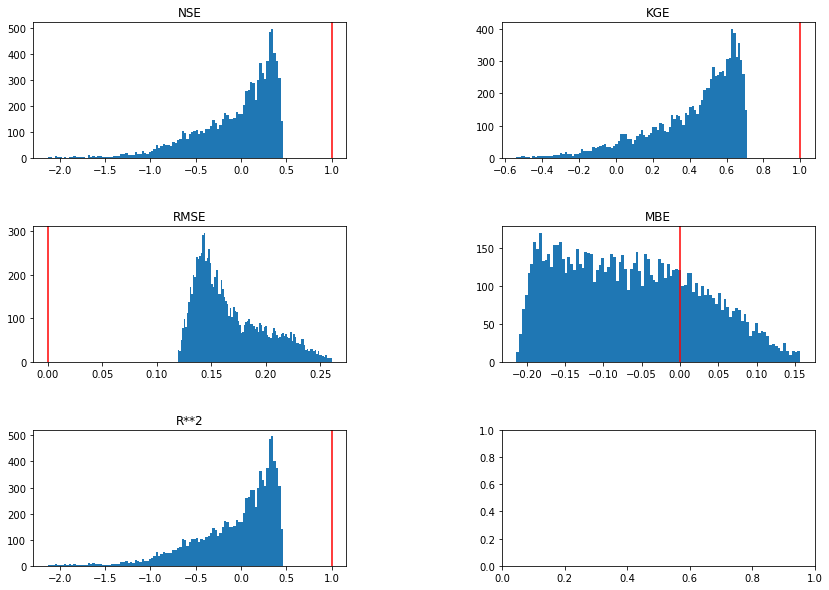

In [12]:
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs[0, 0].hist(dataav['NSE'],bins=100)
axs[0, 0].set_title('NSE')
axs[0, 0].axvline(1,c='r') 
axs[0, 1].hist(dataav['KGE'],bins=100)
axs[0, 1].set_title('KGE')
axs[0, 1].axvline(1,c='r') 
axs[1, 0].hist(dataav['RMSE'],bins=100)
axs[1, 0].set_title('RMSE')
axs[1, 0].axvline(0,c='r') 
axs[1, 1].hist(dataav['MBE'],bins=100)
axs[1, 1].set_title('MBE')
axs[1, 1].axvline(0,c='r') 
axs[2, 0].hist(dataav['R_2'],bins=100)
axs[2, 0].set_title('R**2')
axs[2, 0].axvline(1,c='r') 

In [14]:
fig.savefig(figpath+domain+'_domain_cal_metrics_averaged.pdf', format='pdf', dpi=300)

In [13]:
def get_top_idx(metric):
    if (metric == 'R_2') | (metric == 'NSE')|(metric == 'KGE'):
        x = dataav[metric].values
        index = np.where(x==np.max(x))
    elif (metric == 'MBE'):
        x = np.abs(dataav['MBE']).values
        index = np.where(x==np.min(x))
    elif (metric == 'RMSE'):
        x = dataav[metric]
        index = np.where(x==np.min(x))
    return index[0][0]


top_params = []

top_params.append(get_top_idx('R_2'))
top_params.append(get_top_idx('MBE'))
top_params.append(get_top_idx('RMSE'))
top_params.append(get_top_idx('NSE'))
top_params.append(get_top_idx('KGE'))

top_params

[595, 5729, 856, 595, 855]

In [14]:
#the parameters for the top performing runs
print(domain)
topav = calibration.iloc[top_params]
topav = topav.reset_index(drop=True)
topav

WY


gap_frac  ro_snowmax  cf_precip_scalar  ro_adjust  conifer_lai
0       0.0       450.0               1.0        4.0          2.0
1       0.4       700.0               1.1        4.0          2.8
2       0.0       500.0               1.0        6.0          2.0
3       0.0       450.0               1.0        4.0          2.0
4       0.0       500.0               1.0        6.0          1.8

### Heatmap of top performing runs 

In [15]:
#https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


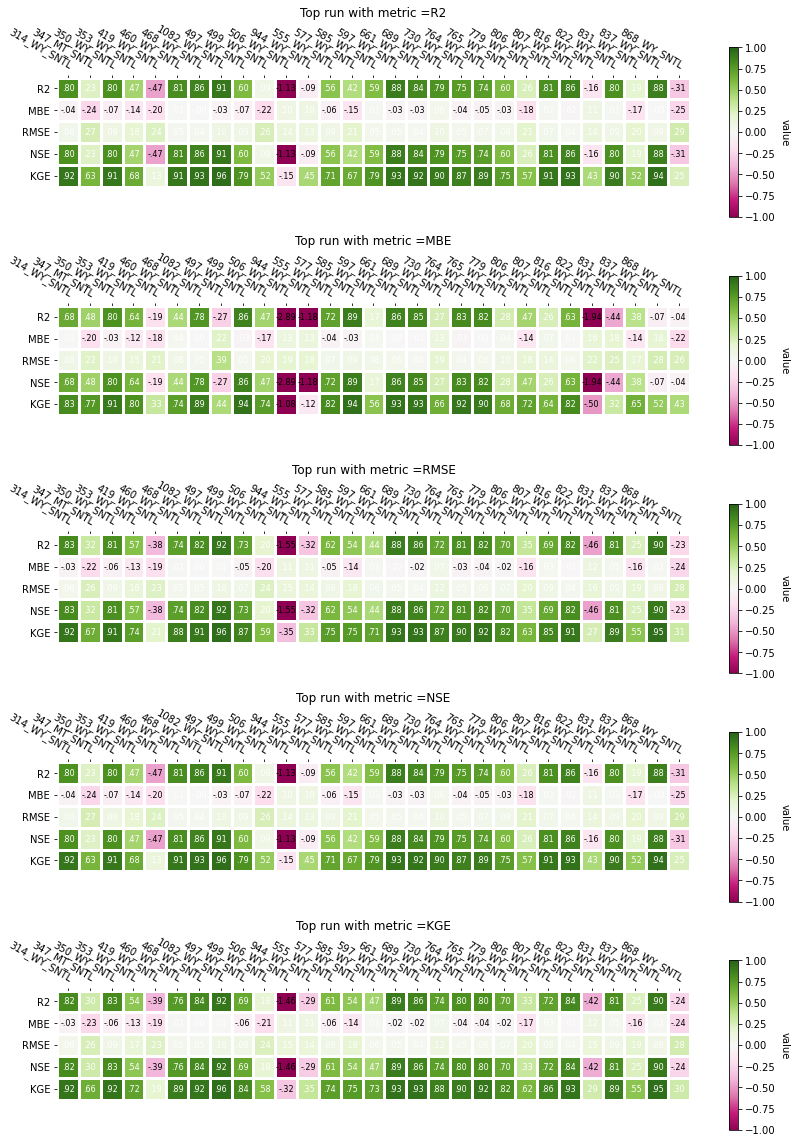

In [16]:
Metrics = ['R2','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")
#WA figsize=(8,16)
fig, ((ax), (ax1), (ax2), (ax3),(ax4)) = plt.subplots(5, 1, figsize=(12,16))

# Replicate the above example with a different font size and colormap.
im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top run with metric ='+Metrics[0])

im, _ = heatmap(data.cal_metrics[top_params[1],:,:], Metrics, Stations, ax=ax1,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax1.set_title('Top run with metric ='+Metrics[1])

im, _ = heatmap(data.cal_metrics[top_params[2],:,:], Metrics, Stations, ax=ax2,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax2.set_title('Top run with metric ='+Metrics[2])

im, _ = heatmap(data.cal_metrics[top_params[3],:,:], Metrics, Stations, ax=ax3,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax3.set_title('Top run with metric ='+Metrics[3])

im, _ = heatmap(data.cal_metrics[top_params[4],:,:], Metrics, Stations, ax=ax4,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax4.set_title('Top run with metric ='+Metrics[4])


plt.tight_layout()
plt.show()

In [19]:
fig.savefig(figpath+domain+'_heatmap_averaged.pdf', format='pdf', dpi=300)

## SWE timeseries with optimal configurations identified above

In [17]:
inswe = swes.cal_metrics[top_params,:,:]
#inswe = inswe.reset_index(drop=True)
inswe

<xarray.DataArray 'cal_metrics' (calibration_run: 5, sim_day: 1857, station: 29)>
[269265 values with dtype=float64]
Coordinates:
  * calibration_run  (calibration_run) int64 595 5729 856 595 855
  * sim_day          (sim_day) int64 0 1 2 3 4 5 ... 1852 1853 1854 1855 1856
  * station          (station) object '314_WY_SNTL' ... '868_WY_SNTL'
Attributes:
    long_name:      swe timeseries [m]
    standard_name:  swe

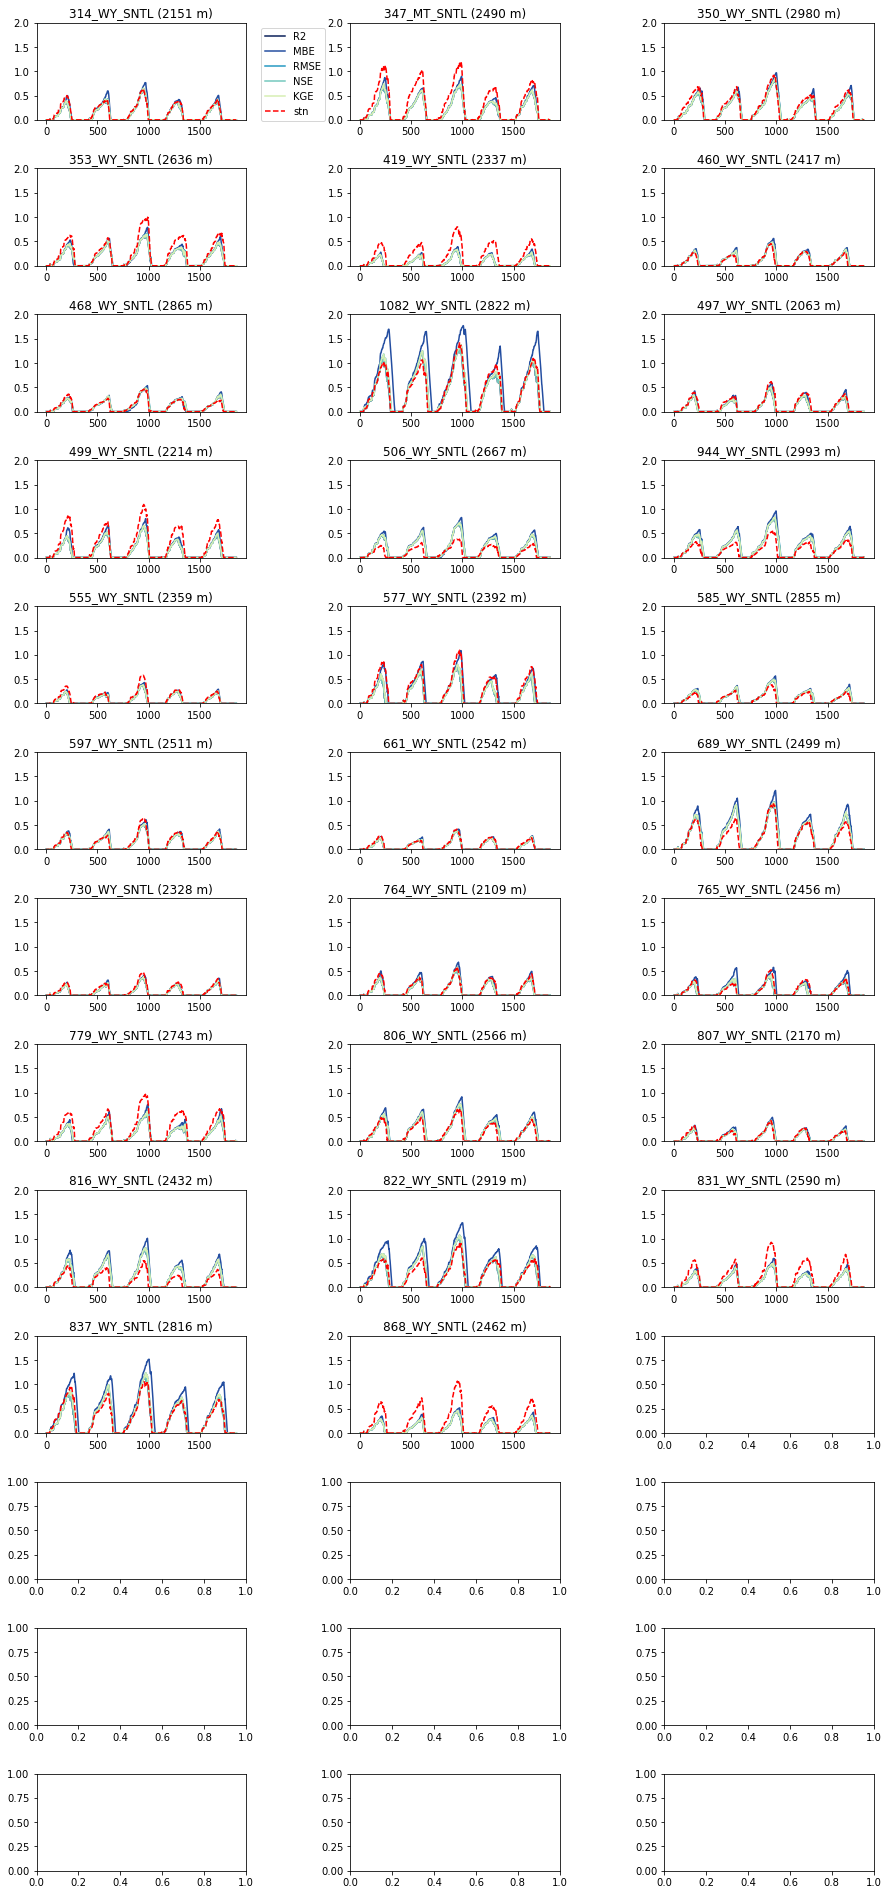

In [18]:
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
#CO_N: nrows=13,figsize=(15, 34) 
fig, axs = plt.subplots(nrows=13,figsize=(15, 34) , ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = inswe.sel(station = nam).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    for j in range(n):
        c=next(color)
        axs[i].plot(np.transpose(mod[j,:]),c=c)
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(['R2','MBE','RMSE','NSE', 'KGE','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [22]:
fig.savefig(figpath+domain+'_SWE_top_calmetrics_'+run_date+'_av.pdf', format='pdf', dpi=300)

# Top ranked score

-> each OF is ranked independently

-> the rank scores are summed across each model run 

-> The summed scores are then ranked and the top scores are used to identify the top model parameter combinations

In [148]:
dataav['NSE_rank']=dataav['NSE'].rank(ascending=False)
dataav['KGE_rank']=dataav['KGE'].rank(ascending=False)
dataav['R_2_rank']=dataav['R_2'].rank(ascending=False)
dataav['RMSE_rank']=dataav['RMSE'].rank()
dataav['MBE_rank']=np.abs(dataav['MBE']).rank()
dataav['score']=dataav['NSE_rank']+ dataav['KGE_rank']+dataav['R_2_rank']+ dataav['RMSE_rank']+dataav['MBE_rank']
dataav['score_rank'] = dataav['score'].rank()
dataav.head()

NSE       KGE      RMSE       R_2       MBE  NSE_rank  KGE_rank  \
0 -0.375643  0.072978  0.145685 -0.375643 -0.106994    2702.0    3895.0   
1 -0.376037  0.084848  0.145758 -0.376037 -0.107044    2710.0    3776.0   
2 -0.376613  0.095822  0.145812 -0.376613 -0.107013    2719.0    3666.0   
3 -0.377904  0.105243  0.145953 -0.377904 -0.107019    2737.0    3552.0   
4 -0.382474  0.111480  0.146217 -0.382474 -0.107099    2787.0    3494.0   

   R_2_rank  RMSE_rank  MBE_rank    score  score_rank  
0    2702.0     4124.0    7911.0  21334.0      4592.0  
1    2710.0     4133.0    7916.0  21245.0      4569.0  
2    2719.0     4144.0    7913.0  21161.0      4547.0  
3    2737.0     4174.0    7914.0  21114.0      4535.0  
4    2787.0     4219.0    7918.0  21205.0      4559.0

In [149]:
rank_params = np.where((dataav['score_rank']==min(dataav['score_rank'])))
top_params = rank_params[0]
label = dataav['score_rank'][top_params].values
top_params

array([2268])

In [150]:
#the parameters for the top performing runs
toprank = calibration.iloc[top_params]
#toprank = dataav.iloc[top_params]
toprank

gap_frac  ro_snowmax  cf_precip_scalar  ro_adjust  conifer_lai
2268       0.2       400.0               0.9        4.0          1.8

Text(0.5, 1.0, 'Top Rank')

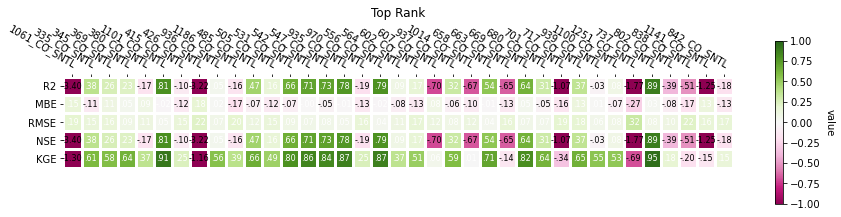

In [151]:
fig, ((ax)) = plt.subplots(1, 1, figsize=(15,3))

# Replicate the above example with a different font size and colormap.
im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top Rank')

In [152]:
fig.savefig(figpath+domain+'_heatmap_rank.pdf', format='pdf', dpi=300)

In [97]:
# #this worked with a smaller calibration parameter set but does not work if their are ties for first place rankings
# rank_params = np.where((dataav['score_rank']==1)|(dataav['score_rank']==2)|(dataav['score_rank']==3))

In [98]:
inswe = swes.cal_metrics[top_params[0],:,:]
inswe

<xarray.DataArray 'cal_metrics' (sim_day: 1857, station: 10)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    calibration_run  int64 431
  * sim_day          (sim_day) int64 0 1 2 3 4 5 ... 1852 1853 1854 1855 1856
  * station          (station) object '1166_OR_SNTL' ... '815_OR_SNTL'
Attributes:
    long_name:      swe timeseries [m]
    standard_name:  swe

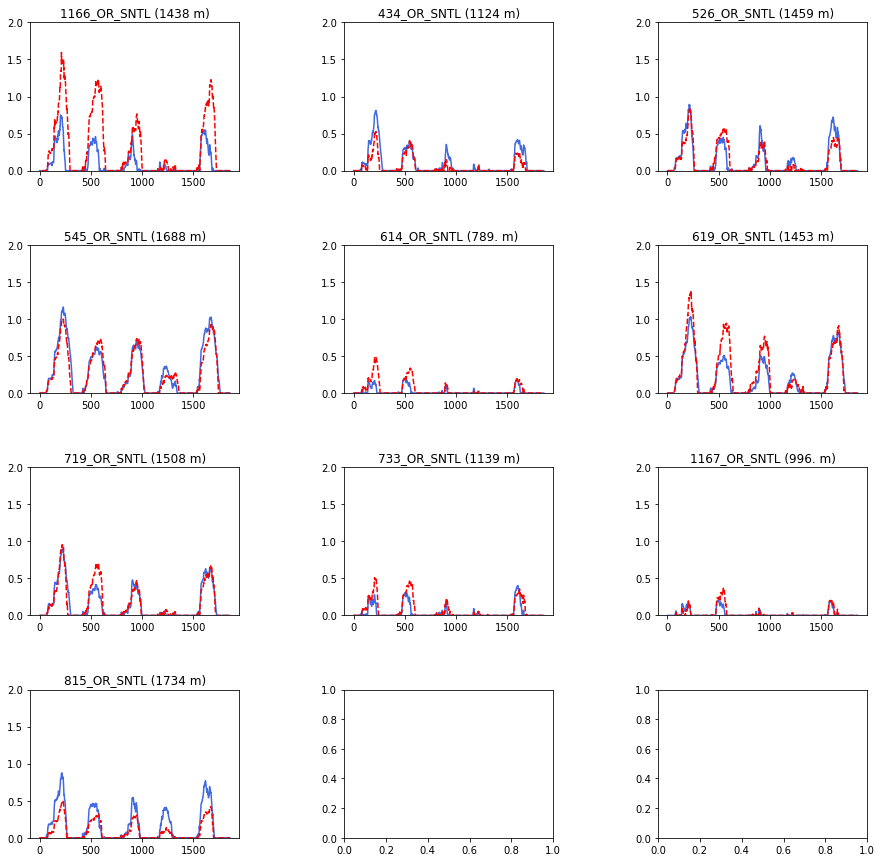

In [99]:
#Ranking plot OR -> one winning rank score 
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0]

fig, axs = plt.subplots(nrows=4, figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = inswe[:,i]
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+2)))
    axs[i].plot(mod,c='royalblue')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
#     if i == 0:
#         axs[i].legend([str(label[0]),str(label[1]),str(label[2]),'stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [100]:
fig.savefig(figpath+domain+'_SWE_top_calmetrics_'+run_date+'_rank.pdf', format='pdf', dpi=300)

# Set up full run of SM based on above findings

In [23]:
OF = 'NSE'

#the parameters for the top performing runs
calibration.loc[get_top_idx(OF)]

gap_frac              0.0
ro_snowmax          450.0
cf_precip_scalar      1.2
ro_adjust             6.0
conifer_lai           3.0
Name: 672, dtype: float64

In [24]:
calibration.conifer_lai.loc[get_top_idx(OF)]

3.0

In [134]:
# run line model of SM with top params


parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'
micrometFile = SMpath+'code/micromet_code.f'


#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value,parFile):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108 \
    or par_dict[parameter][2] == 147 or par_dict[parameter][2] == 148 \
    or par_dict[parameter][2] == 149:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()
    
#base .par
basepar_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/calibration_python/master/par_base.json")
base = basepar_resp.json()

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(np.shape(gdf)[0]+1)+',ny_max=2)\n')
replace_line(micrometFile, 3336,'      data vlai_summer /'+str(calibration.conifer_lai.loc[get_top_idx(OF)])+', 2.5, 2.5, 1.5, 1.0/\n')
replace_line(micrometFile, 3337,'      data vlai_winter /'+str(calibration.conifer_lai.loc[get_top_idx(OF)])+', 0.5, 1.5, 1.5, 1.0/\n')

edit_par(base,'snowmodel_line_flag',1,parFile)
edit_par(base,'topo_ascii_fname','../../CSOdmn/'+domain+'/DEM_'+domain+'_line.asc',parFile)
edit_par(base,'veg_ascii_fname','../../CSOdmn/'+domain+'/NLCD2016_'+domain+'_line.asc',parFile)
edit_par(base,'lat_file_path','../../CSOdmn/'+domain+'/grid_lat_'+domain+'_line.asc',parFile)
edit_par(base,'lon_file_path','../../CSOdmn/'+domain+'/grid_lon_'+domain+'_line.asc',parFile)
edit_par(base,'nx',np.shape(gdf)[0],parFile)
edit_par(base,'ny',1,parFile)
edit_par(base,'ro_snowmax',calibration.ro_snowmax.loc[get_top_idx(OF)],parFile)
edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar.loc[get_top_idx(OF)],parFile)
edit_par(base,'ro_adjust',calibration.ro_adjust.loc[get_top_idx(OF)],parFile) 
edit_par(base,'gap_frac',calibration.gap_frac.loc[get_top_idx(OF)],parFile) 
edit_par(base,'print_var_01','y',parFile)#tair
edit_par(base,'print_var_09','y',parFile)#prec
edit_par(base,'print_var_10','n',parFile)#rain
edit_par(base,'print_var_11','n',parFile)#sprec
edit_par(base,'print_var_12','n',parFile)#swemelt
edit_par(base,'print_var_14','n',parFile)#runoff
edit_par(base,'print_var_18','y',parFile)#swed
edit_par(base,'print_var_19','y',parFile)#sspr
edit_par(base,'print_var_20','y',parFile)#ssmt


    
#run compile script 
#Compile SnowModel

%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_OR/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [25]:
# need to discuss how to choose the top - currently set up to analyze based on OF
# SM location 
#SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY/'


parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'
micrometFile = SMpath+'code/micromet_code.f'


#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value,parFile):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108 \
    or par_dict[parameter][2] == 147 or par_dict[parameter][2] == 148 \
    or par_dict[parameter][2] == 149:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()
    
#base .par
basepar_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/calibration_python/master/par_base.json")
base = basepar_resp.json()

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(int(domains[domain]['ncols'])+1)
             +',ny_max='+str(int(domains[domain]['nrows'])+1)+')\n')#full domain
replace_line(micrometFile, 3336,'      data vlai_summer /'+str(calibration.conifer_lai.loc[get_top_idx(OF)])+', 2.5, 2.5, 1.5, 1.0/\n')
replace_line(micrometFile, 3337,'      data vlai_winter /'+str(calibration.conifer_lai.loc[get_top_idx(OF)])+', 0.5, 1.5, 1.5, 1.0/\n')

#remove line flag
edit_par(base,'snowmodel_line_flag',0,parFile)
edit_par(base,'topo_ascii_fname','../../CSOdmn/'+domain+'/DEM_'+domain+'.asc',parFile)
edit_par(base,'veg_ascii_fname','../../CSOdmn/'+domain+'/NLCD2016_'+domain+'.asc',parFile)
edit_par(base,'lat_file_path','../../CSOdmn/'+domain+'/grid_lat_'+domain+'.asc',parFile)
edit_par(base,'lon_file_path','../../CSOdmn/'+domain+'/grid_lon_'+domain+'.asc',parFile)
edit_par(base,'nx',domains[domain]['ncols'],parFile)
edit_par(base,'ny',domains[domain]['nrows'],parFile)
#edit_par(base,'lat_solar_flag',calibration.lat_solar_flag.loc[get_top_idx(OF)])
#edit_par(base,'wind_lapse_rate',calibration.wind_lapse_rate.loc[get_top_idx(OF)])
#edit_par(base,'lapse_rate',calibration.lapse_rate.loc[get_top_idx(OF)])
#edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate.loc[get_top_idx(OF)])
edit_par(base,'ro_snowmax',calibration.ro_snowmax.loc[get_top_idx(OF)],parFile)
edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar.loc[get_top_idx(OF)],parFile)
edit_par(base,'ro_adjust',calibration.ro_adjust.loc[get_top_idx(OF)],parFile) 
edit_par(base,'gap_frac',calibration.gap_frac.loc[get_top_idx(OF)],parFile) 
edit_par(base,'print_var_01','y',parFile)#tair
edit_par(base,'print_var_09','y',parFile)#prec
edit_par(base,'print_var_10','n',parFile)#rain
edit_par(base,'print_var_11','n',parFile)#sprec
edit_par(base,'print_var_12','n',parFile)#swemelt
edit_par(base,'print_var_14','n',parFile)#runoff
edit_par(base,'print_var_18','y',parFile)#swed
edit_par(base,'print_var_19','y',parFile)#sspr
edit_par(base,'print_var_20','y',parFile)#ssmt
#edit_par(base,'run_snowtran',1,parFile)


    
#run compile script 
#Compile SnowModel

%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_WA_SQ/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [34]:
#Edit
datapath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
SMpath_extra = SMpath+'/extra_met/'
#have to change out extramet files to use full domain - not line
latpath = datapath+'grid_lat.asc'
lonpath = datapath+'grid_lon.asc'
!cp $latpath $SMpath_extra
!cp $lonpath $SMpath_extra

# #remove hohup file 
# nohup = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill'+domain+'/nohup.out'
# !rm $nohup

# in command line - initiate the full model run
# $ cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/
# $ ! nohup ./snowmodel

# Compare line output to saved calibration output 

In [ ]:
#https://github.com/miniufo/xgrads/issues/23
#https://cablab.readthedocs.io/en/latest/dat_python.html

In [179]:
def get_mod_output_lines(inFile):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_sim_days,1,np.shape(gdf)[0]))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,:]) 

    return data

In [182]:
sweFile = SMpath+'outputs/wo_assim/swed.gdat'
mod_swe = get_mod_output_lines(sweFile)
np.shape(mod_swe)

(1857, 37)

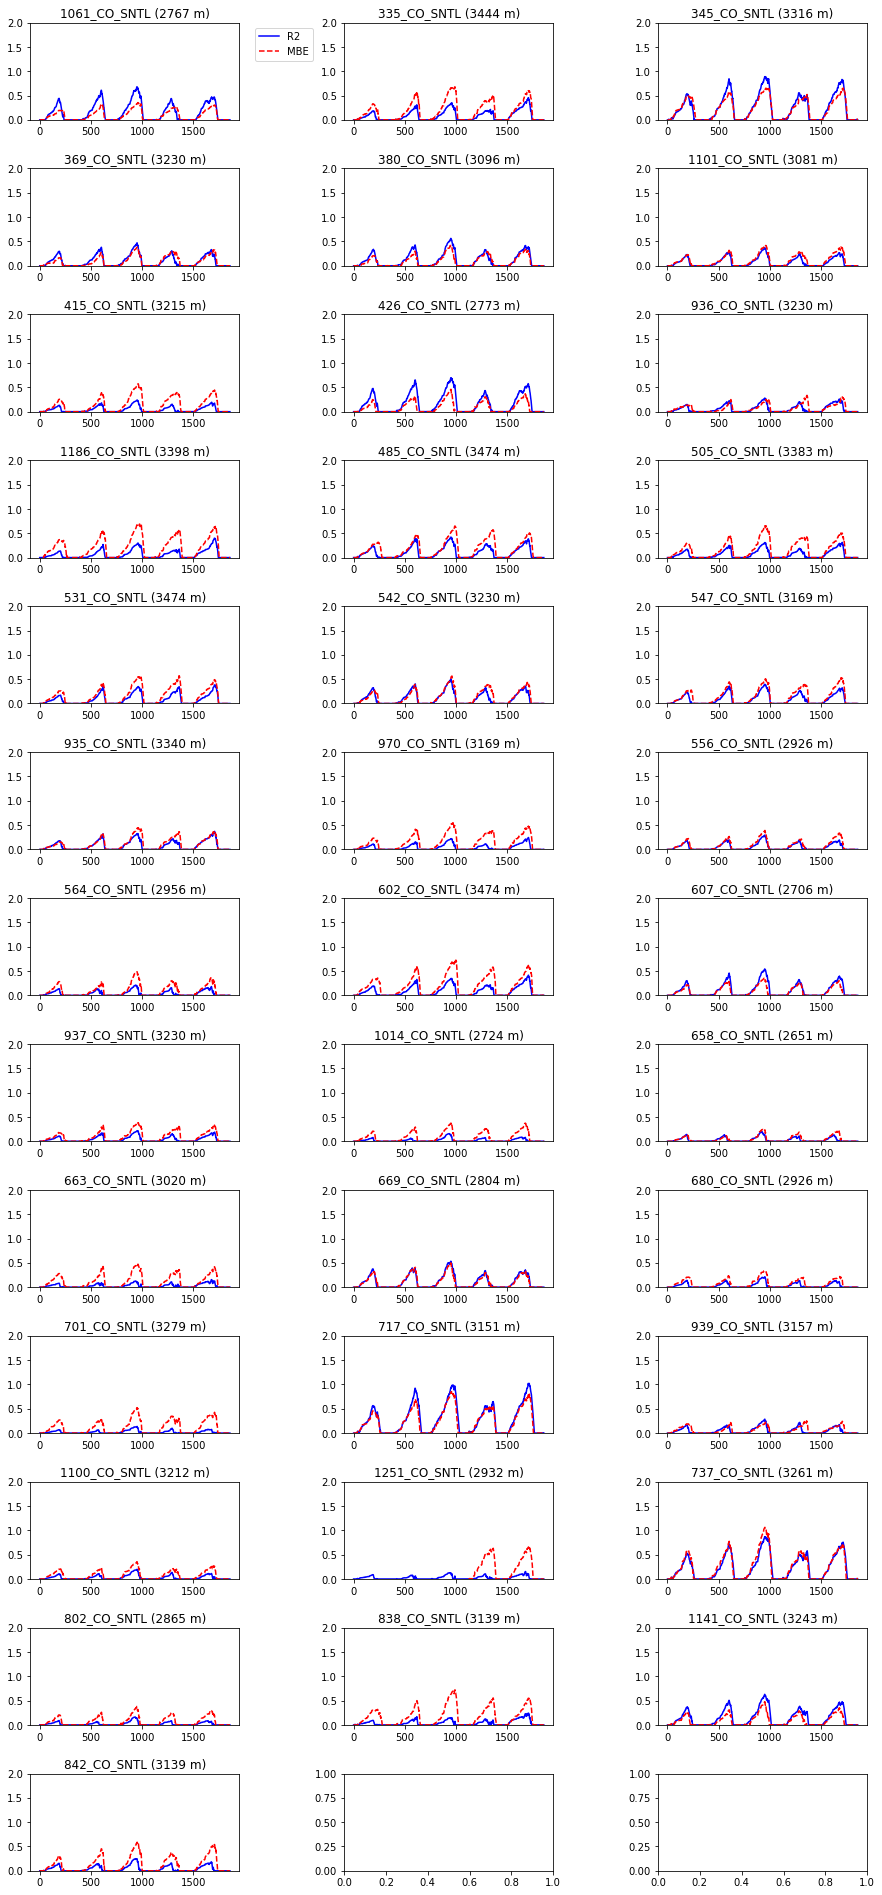

In [186]:
sweFile = SMpath+'outputs/wo_assim/swed.gdat'
mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=13, figsize=(15, 34), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = mod_swe[:,i]#inswe.sel(station = nam).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,c='b')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(['R2','MBE','RMSE','NSE', 'KGE','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

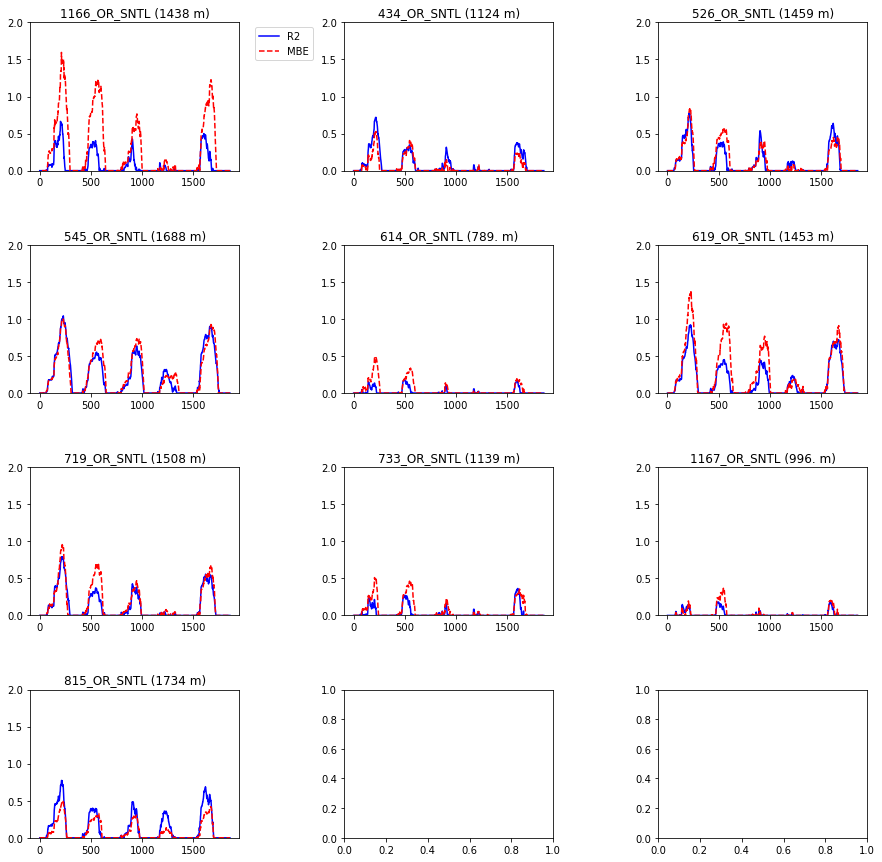

In [55]:
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=4, figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = inswe.sel(station = nam).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(np.transpose(mod[0,:]),c='b')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(['R2','MBE','RMSE','NSE', 'KGE','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [ ]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################
# DOMAIN
# choose the modeling domain
domain = 'WY'
print(domain)

domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
# PATHS
# path to domain data folder 
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
# path to store tif files from gee
#TIFpath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/GEE/'
# # path to where you want your output met .dat fime
# OUTpath = 'OR_met_test.dat'#'/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/mm_'+domain+'_2011-2016.dat'

# TIME
# choose if want to set 'manual' or 'auto' date 
date_flag = 'manual'
# If you choose 'manual' set your dates below  
# This will start on the 'begin' date at 0:00 and the last iteration will 
# be on the day before the 'end' date below.
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']
# gee dates 
stdt=st_dt
eddt=(datetime.strptime(ed_dt,'%Y-%m-%d')+timedelta(days=1)).strftime("%Y-%m-%d")

nx = int(domains[domain]['ncols'])
ny = int(domains[domain]['nrows'])
xll = int(domains[domain]['xll'])
yll = int(domains[domain]['yll'])
clsz = int(domains[domain]['cellsize'])

# number of timesteps in model run 
num_mod_timesteps = (datetime.strptime(ed_dt,'%Y-%m-%d')-datetime.strptime(st_dt,'%Y-%m-%d')).days+1
#########################################################################

In [59]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'

domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']

# load the precip data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_PRmeters'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_pr=dftemp.set_index(dftemp.datetime,drop=True)
stn_pr

Unnamed: 0  1166_OR_SNTL  434_OR_SNTL  526_OR_SNTL  545_OR_SNTL  \
datetime                                                                      
2011-09-01  2011-09-01           NaN      0.00000          0.0          0.0   
2011-09-02  2011-09-02           NaN      0.00000          0.0          0.0   
2011-09-03  2011-09-03           NaN      0.00000          0.0          0.0   
2011-09-04  2011-09-04           NaN      0.00000          0.0          0.0   
2011-09-05  2011-09-05           NaN      0.00000          0.0          0.0   
...                ...           ...          ...          ...          ...   
2016-09-26  2016-09-26           0.0      0.00000          0.0          0.0   
2016-09-27  2016-09-27           0.0      0.00254          0.0          0.0   
2016-09-28  2016-09-28           0.0      0.00254          0.0          0.0   
2016-09-29  2016-09-29           0.0      0.00254          0.0          0.0   
2016-09-30  2016-09-30           0.0      0.00254          0.0          0.0   

            614_OR_SNTL  619_OR_SNTL  719_OR_SNTL  733_OR_SNTL  1167_OR_SNTL  \
datetime                                                                       
2011-09-01      0.00000          0.0          0.0          0.0           NaN   
2011-09-02      0.00000          0.0          0.0          0.0           NaN   
2011-09-03      0.00000          0.0          0.0          0.0           NaN   
2011-09-04      0.00000          0.0          0.0          0.0           NaN   
2011-09-05      0.00000          0.0          0.0          0.0           NaN   
...                 ...          ...          ...          ...           ...   
2016-09-26      0.00000          0.0          0.0          0.0           0.0   
2016-09-27      0.00000          0.0          0.0          0.0           0.0   
2016-09-28      0.00000          0.0          0.0          0.0           0.0   
2016-09-29      0.00000          0.0          0.0          0.0           0.0   
2016-09-30      0.00254          0.0          0.0          0.0           0.0   

            815_OR_SNTL   datetime  
datetime                            
2011-09-01      0.01016 2011-09-01  
2011-09-02      0.00000 2011-09-02  
2011-09-03      0.00000 2011-09-03  
2011-09-04      0.00000 2011-09-04  
2011-09-05      0.00000 2011-09-05  
...                 ...        ...  
2016-09-26      0.00000 2016-09-26  
2016-09-27      0.00000 2016-09-27  
2016-09-28      0.00000 2016-09-28  
2016-09-29      0.00000 2016-09-29  
2016-09-30      0.00000 2016-09-30  

[1857 rows x 12 columns]

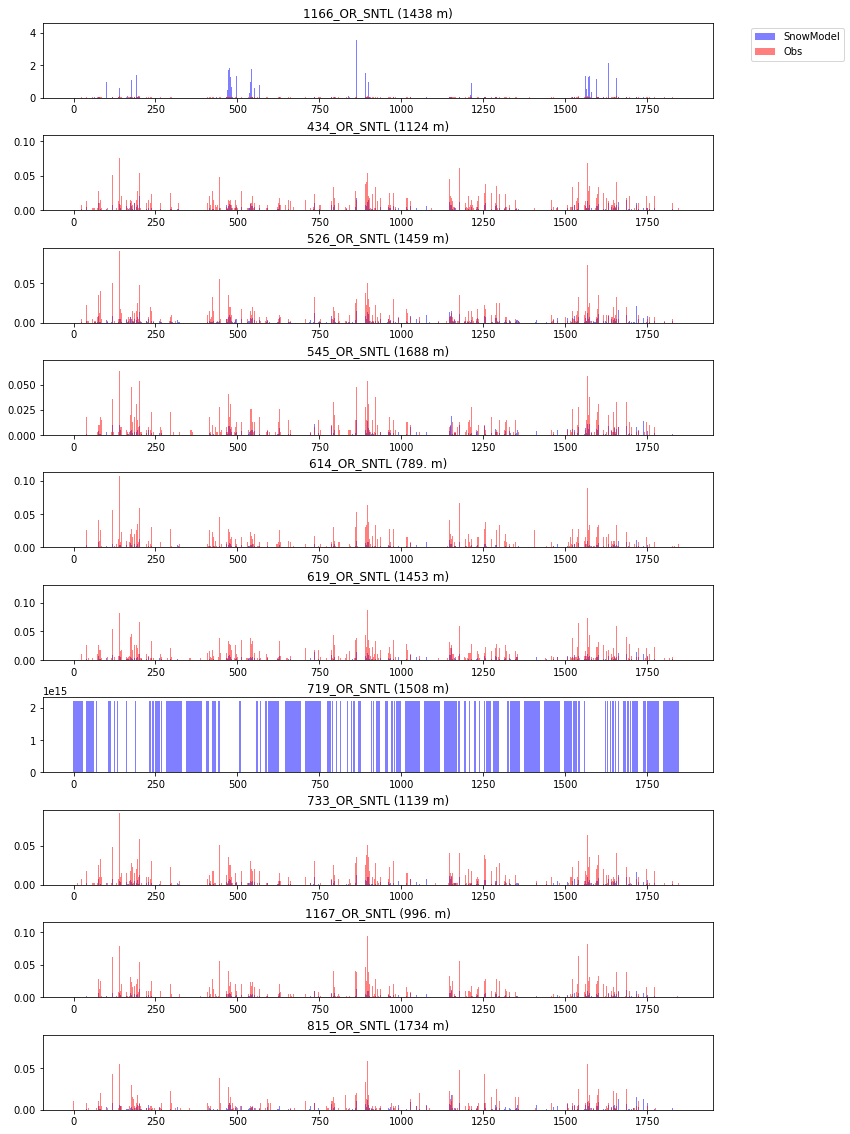

In [71]:
sweFile = SMpath+'outputs/wo_assim/prec_line.gdat'
mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_pr[nam].values
    mod = mod_swe[:,i]#inswe.sel(station = nam).values
    x = np.arange(len(mod))
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].bar(x,mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].bar(x,obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

In [79]:
# load the temp data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_TAVGcelsius'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_temp=dftemp.set_index(dftemp.datetime,drop=True)
stn_temp

Unnamed: 0  1166_OR_SNTL  434_OR_SNTL  526_OR_SNTL  545_OR_SNTL  \
datetime                                                                      
2011-09-01  2011-09-01           NaN         12.6         10.4          8.1   
2011-09-02  2011-09-02           NaN         15.1         13.9         11.5   
2011-09-03  2011-09-03           NaN         18.9         14.3         12.3   
2011-09-04  2011-09-04           NaN         21.2         17.7         14.0   
2011-09-05  2011-09-05           NaN         19.5         17.5         14.5   
...                ...           ...          ...          ...          ...   
2016-09-26  2016-09-26          19.1         20.5         17.6         13.4   
2016-09-27  2016-09-27          15.0         15.1         14.6         11.9   
2016-09-28  2016-09-28          13.9         12.9         13.4         11.1   
2016-09-29  2016-09-29          11.3         11.0         10.9          9.5   
2016-09-30  2016-09-30           8.0          9.1          8.1          6.5   

            614_OR_SNTL  619_OR_SNTL  719_OR_SNTL  733_OR_SNTL  1167_OR_SNTL  \
datetime                                                                       
2011-09-01         10.9          7.9          9.9         10.3           NaN   
2011-09-02         12.6         11.4         13.1         13.6           NaN   
2011-09-03         14.4         14.9         16.9         17.5           NaN   
2011-09-04         15.4         14.4         19.7         20.2           NaN   
2011-09-05         16.3         14.3         17.8         16.8           NaN   
...                 ...          ...          ...          ...           ...   
2016-09-26         13.8         13.7         19.2         19.0          22.0   
2016-09-27         13.0         10.8         14.1         13.4          17.0   
2016-09-28         12.6         10.0         13.4         12.5          14.9   
2016-09-29         11.2          8.1         11.2         10.2          12.9   
2016-09-30          9.5          6.4          7.5          8.4          10.9   

            815_OR_SNTL   datetime  
datetime                            
2011-09-01          8.8 2011-09-01  
2011-09-02         12.0 2011-09-02  
2011-09-03         11.0 2011-09-03  
2011-09-04         17.5 2011-09-04  
2011-09-05         16.1 2011-09-05  
...                 ...        ...  
2016-09-26         18.5 2016-09-26  
2016-09-27         15.2 2016-09-27  
2016-09-28         13.7 2016-09-28  
2016-09-29         13.8 2016-09-29  
2016-09-30          9.9 2016-09-30  

[1857 rows x 12 columns]

In [113]:
def get_mod_output_lines(inFile):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_sim_days,1,np.shape(gdf)[0]))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,:]) 
    return data

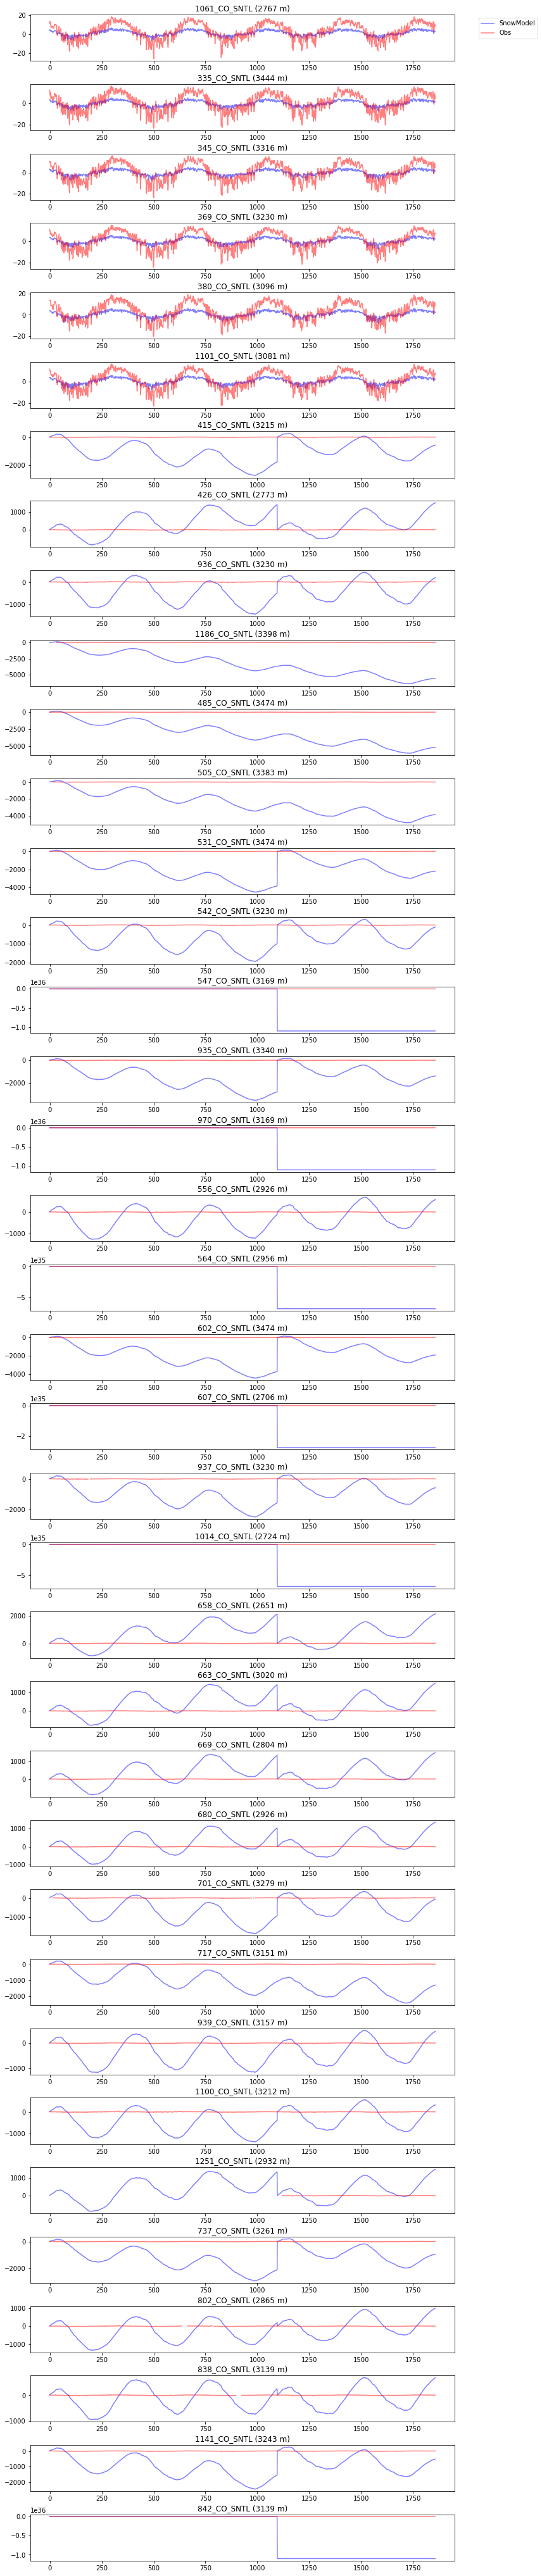

In [218]:
sweFile = SMpath+'outputs/wo_assim/tair.gdat'
mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_temp[nam].values
    mod = mod_swe[:,i]#inswe.sel(station = nam).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].plot(obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

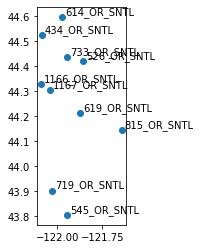

In [122]:
ax = gdf.plot()

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.code):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [121]:
gdf

code   longitude   latitude                 name  \
0  1166_OR_SNTL -122.093803  44.325298           Bear Grass   
1   434_OR_SNTL -122.087181  44.521469            Daly Lake   
2   526_OR_SNTL -121.856552  44.420422            Hogg Pass   
3   545_OR_SNTL -121.947929  43.803680         Irish Taylor   
4   614_OR_SNTL -121.973648  44.593971         Marion Forks   
5   619_OR_SNTL -121.872917  44.210300             Mckenzie   
6   719_OR_SNTL -122.030632  43.900982        Roaring River   
7   733_OR_SNTL -121.945023  44.435032         Santiam Jct.   
8  1167_OR_SNTL -122.040527  44.303249          Smith Ridge   
9   815_OR_SNTL -121.640953  44.144249  Three Creeks Meadow   

          elevation_m        easting      northing  \
0   1438.656005859375  572255.451212  4.908403e+06   
1  1124.7120361328125  572540.471215  4.930199e+06   
2   1459.991943359375  591025.222762  4.919206e+06   
3   1688.592041015625  584626.662707  4.850606e+06   
4   789.4320068359375  581461.571806  4.938360e+06   
5    1453.89599609375  590043.243451  4.895848e+06   
6   1508.760009765625  577847.500754  4.861332e+06   
7  1139.9520263671875  583961.512473  4.920734e+06   
8  996.69598388671875  576532.073321  4.906003e+06   
9    1734.31201171875  608696.366131  4.888792e+06   

                      geometry  
0  POINT (-122.09380 44.32530)  
1  POINT (-122.08718 44.52147)  
2  POINT (-121.85655 44.42042)  
3  POINT (-121.94793 43.80368)  
4  POINT (-121.97365 44.59397)  
5  POINT (-121.87292 44.21030)  
6  POINT (-122.03063 43.90098)  
7  POINT (-121.94502 44.43503)  
8  POINT (-122.04053 44.30325)  
9  POINT (-121.64095 44.14425)

In [23]:
from xgrads import CtlDescriptor

In [136]:
# path to sm outputs 
SMpath = '/nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_'+domain+'/'
SMtemp = SMpath + 'outputs/wo_assim/tair_full.gdat'
SMprec = SMpath + 'outputs/wo_assim/prec_fill.gdat'
SMswed = SMpath + 'outputs/wo_assim/swed_full.gdat'

nx = int(domains[domain]['ncols'])
ny = int(domains[domain]['nrows'])
xll = int(domains[domain]['xll'])
yll = int(domains[domain]['yll'])
clsz = int(domains[domain]['cellsize'])

In [141]:
ctlFile = SMpath+'ctl_files/wo_assim/swed_line.ctl'

In [25]:
ctl = CtlDescriptor(file=ctlFile)

# print all the info in ctl file
print(ctl)

   dsetPath: /nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_OR/ctl_files/wo_assim/../../outputs/wo_assim/swed.gdat
   descPath: /nfs/attic/dfh/Aragon2/CSOsm/jan2021_snowmodel-dfhill_OR/ctl_files/wo_assim/swed.ctl
   indxPath: 
   stnmPath: 
      title: SnowModel
      undef: -9999.0
       zrev: False
       yrev: False
      dtype: 
   template: False
  periodicX: False
 cal365Days: False
 sequential: False
  byteOrder: little
       xdef: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.

In [142]:
from xgrads import open_CtlDataset

dset = open_CtlDataset(ctlFile)

# print all the info in ctl file
print(dset)

<xarray.Dataset>
Dimensions:  (lat: 1, lon: 10, time: 1857)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-01 2011-09-02 ... 2016-09-30
  * lat      (lat) float32 1.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    swed     (time, lat, lon) float32 dask.array<chunksize=(1857, 1, 10), meta=np.ndarray>
Attributes:
    title:    SnowModel
    undef:    -9999.0
    pdef:     None


<xarray.Dataset>
Dimensions:  (lat: 1, lon: 10, time: 1857)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-01 2011-09-02 ... 2016-09-30
  * lat      (lat) float32 1.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
Data variables:
    swed     (time, lat, lon) float32 dask.array<chunksize=(1857, 1, 10), meta=np.ndarray>
Attributes:
    title:    SnowModel
    undef:    -9999.0
    pdef:     None


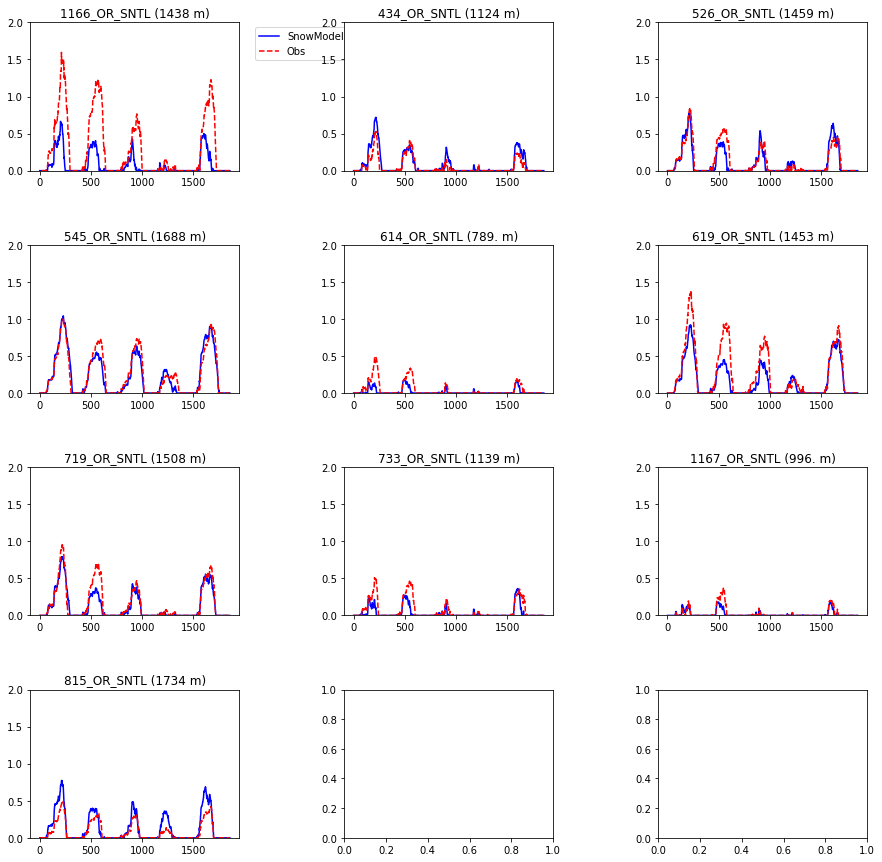

In [145]:
ctlFile = SMpath+'ctl_files/wo_assim/swed_line.ctl'
dset = open_CtlDataset(ctlFile)

# print all the info in ctl file
print(dset)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=4, figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    stn = df[nam].values
    mod = dset.swed.sel(lat = 1, lon = i+1).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,c='b', label = "SnowModel")
    axs[i].plot(stn,'r--',label="Obs")
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

In [35]:
dset.swed.where(dset['swed'] != -9999.)

<xarray.DataArray 'swed' (time: 1857, lat: 1231, lon: 821)>
dask.array<where, shape=(1857, 1231, 821), dtype=float32, chunksize=(1, 1231, 821), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-01 2011-09-02 ... 2016-09-30
  * lat      (lat) float32 1.0 2.0 3.0 4.0 5.0 ... 1228.0 1229.0 1230.0 1231.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 817.0 818.0 819.0 820.0 821.0
Attributes:
    comment:  snow-water-equivalent depth
    storage:  0

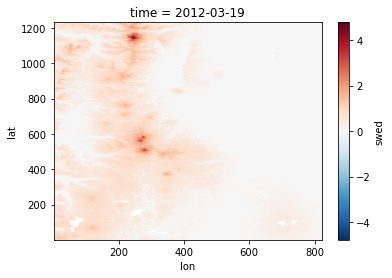

In [36]:
mod = dset.swed.where(dset['swed'] != -9999.).sel(time = dset.time[200])
mod.plot()

In [103]:
gdf

code   longitude   latitude                 name  \
0  1166_OR_SNTL -122.093803  44.325298           Bear Grass   
1   434_OR_SNTL -122.087181  44.521469            Daly Lake   
2   526_OR_SNTL -121.856552  44.420422            Hogg Pass   
3   545_OR_SNTL -121.947929  43.803680         Irish Taylor   
4   614_OR_SNTL -121.973648  44.593971         Marion Forks   
5   619_OR_SNTL -121.872917  44.210300             Mckenzie   
6   719_OR_SNTL -122.030632  43.900982        Roaring River   
7   733_OR_SNTL -121.945023  44.435032         Santiam Jct.   
8  1167_OR_SNTL -122.040527  44.303249          Smith Ridge   
9   815_OR_SNTL -121.640953  44.144249  Three Creeks Meadow   

          elevation_m        easting      northing  \
0   1438.656005859375  572255.451212  4.908403e+06   
1  1124.7120361328125  572540.471215  4.930199e+06   
2   1459.991943359375  591025.222762  4.919206e+06   
3   1688.592041015625  584626.662707  4.850606e+06   
4   789.4320068359375  581461.571806  4.938360e+06   
5    1453.89599609375  590043.243451  4.895848e+06   
6   1508.760009765625  577847.500754  4.861332e+06   
7  1139.9520263671875  583961.512473  4.920734e+06   
8  996.69598388671875  576532.073321  4.906003e+06   
9    1734.31201171875  608696.366131  4.888792e+06   

                      geometry  
0  POINT (-122.09380 44.32530)  
1  POINT (-122.08718 44.52147)  
2  POINT (-121.85655 44.42042)  
3  POINT (-121.94793 43.80368)  
4  POINT (-121.97365 44.59397)  
5  POINT (-121.87292 44.21030)  
6  POINT (-122.03063 43.90098)  
7  POINT (-121.94502 44.43503)  
8  POINT (-122.04053 44.30325)  
9  POINT (-121.64095 44.14425)

In [102]:
station

array(['1166_OR_SNTL', '434_OR_SNTL', '526_OR_SNTL', '545_OR_SNTL',
       '614_OR_SNTL', '619_OR_SNTL', '719_OR_SNTL', '733_OR_SNTL',
       '1167_OR_SNTL', '815_OR_SNTL'], dtype=object)

In [72]:
np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))

(array([19]),)

In [87]:
xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
xval

19

In [88]:
yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
yval

756

KeyError: 19.0

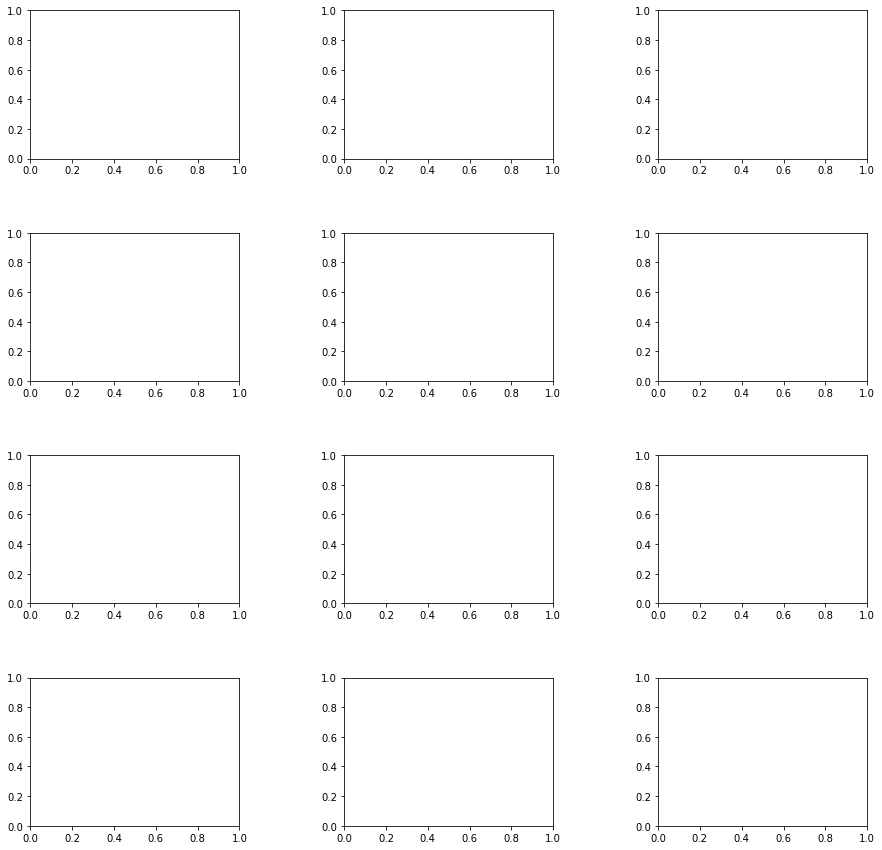

In [137]:
fig, axs = plt.subplots(nrows=4, figsize=(15, 15), ncols=3,facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()

for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    stn = df[nam].values
    pt = (gdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,gdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    mod = dset.swed.sel(lon = xval,lat = yval).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,c='b', label = 'mod')
    axs[i].plot(stn,'r--', label = 'obs')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

In [ ]:
fig, axs = plt.subplots(igsize=(6, 8),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(1):#np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = dset.swed.sel(lon = dset.lon[i],lat = 1).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,c='b')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(['R2','MBE','RMSE','NSE', 'KGE','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [104]:
#Build lat/lon array 
eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)
eas

array([570450., 570550., 570650., 570750., 570850., 570950., 571050.,
       571150., 571250., 571350., 571450., 571550., 571650., 571750.,
       571850., 571950., 572050., 572150., 572250., 572350., 572450.,
       572550., 572650., 572750., 572850., 572950., 573050., 573150.,
       573250., 573350., 573450., 573550., 573650., 573750., 573850.,
       573950., 574050., 574150., 574250., 574350., 574450., 574550.,
       574650., 574750., 574850., 574950., 575050., 575150., 575250.,
       575350., 575450., 575550., 575650., 575750., 575850., 575950.,
       576050., 576150., 576250., 576350., 576450., 576550., 576650.,
       576750., 576850., 576950., 577050., 577150., 577250., 577350.,
       577450., 577550., 577650., 577750., 577850., 577950., 578050.,
       578150., 578250., 578350., 578450., 578550., 578650., 578750.,
       578850., 578950., 579050., 579150., 579250., 579350., 579450.,
       579550., 579650., 579750., 579850., 579950., 580050., 580150.,
       580250., 5803

In [113]:
eas = np.arange(xll, xll+nx*clsz, clsz)
nor = np.arange(yll, yll+ny*clsz, clsz)

KeyError: 19.0

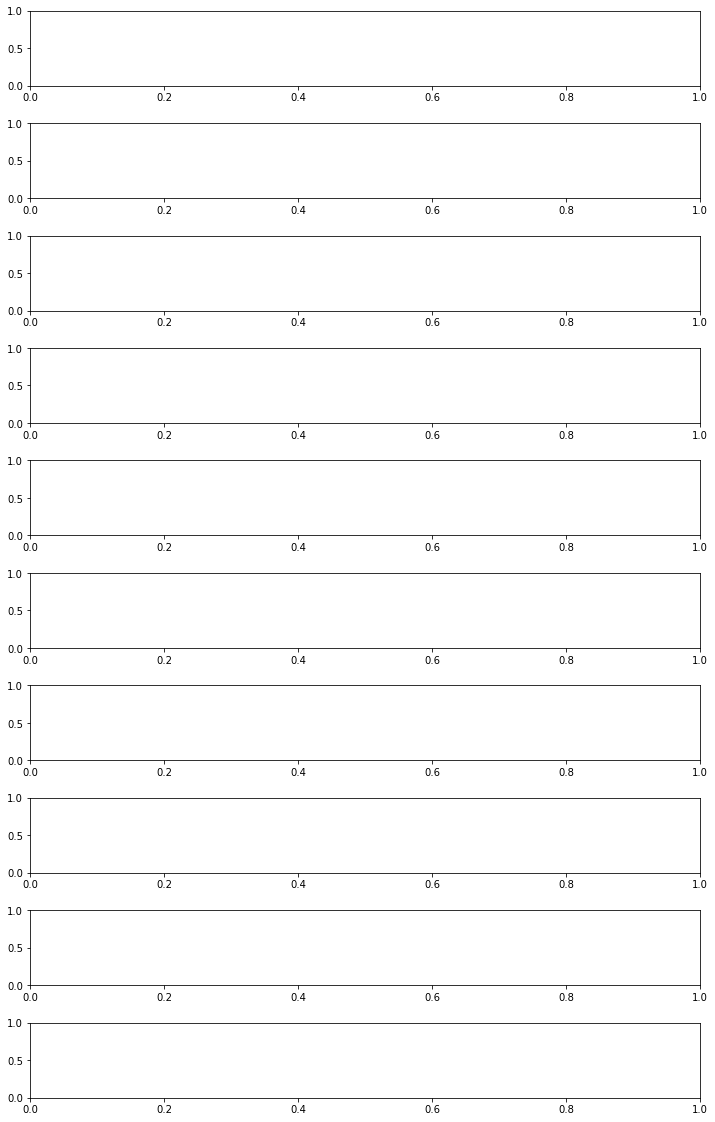

In [146]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']

# load the temp data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_TAVGcelsius'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_temp=dftemp.set_index(dftemp.datetime,drop=True)
stn_temp

ctlFile = SMpath+'ctl_files/wo_assim/tair.ctl'
dset = open_CtlDataset(ctlFile)
#mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_temp[nam].values
    pt = (gdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,gdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    mod = dset.tair.sel(lon = xval,lat = yval).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].plot(obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

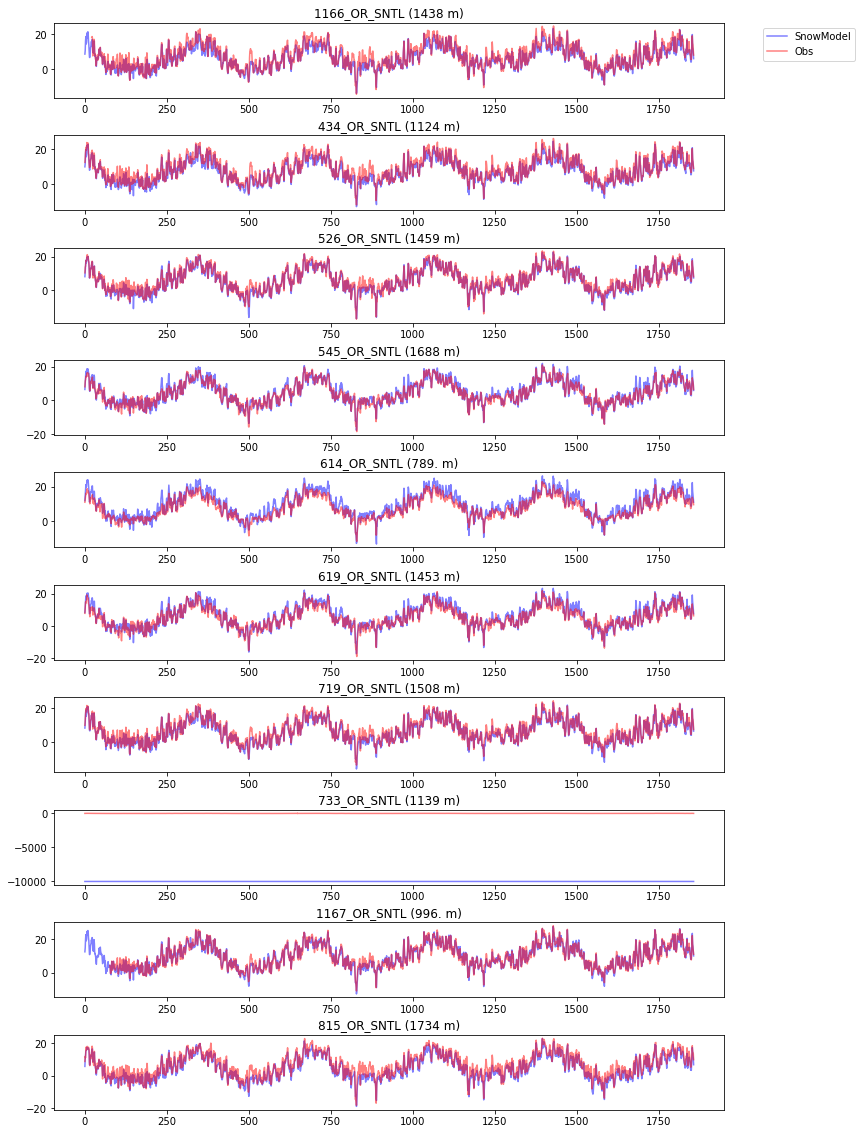

In [112]:
eas = np.arange(xll+.5*clsz, (xll+.5*clsz)+nx*clsz, clsz)
nor = np.arange(yll+.5*clsz, (yll+.5*clsz)+ny*clsz, clsz)

dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']

# load the temp data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_TAVGcelsius'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_temp=dftemp.set_index(dftemp.datetime,drop=True)
stn_temp

ctlFile = SMpath+'ctl_files/wo_assim/tair.ctl'
dset = open_CtlDataset(ctlFile)
#mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_temp[nam].values
    pt = (gdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,gdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    mod = dset.tair.sel(lon = xval,lat = yval).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].plot(obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

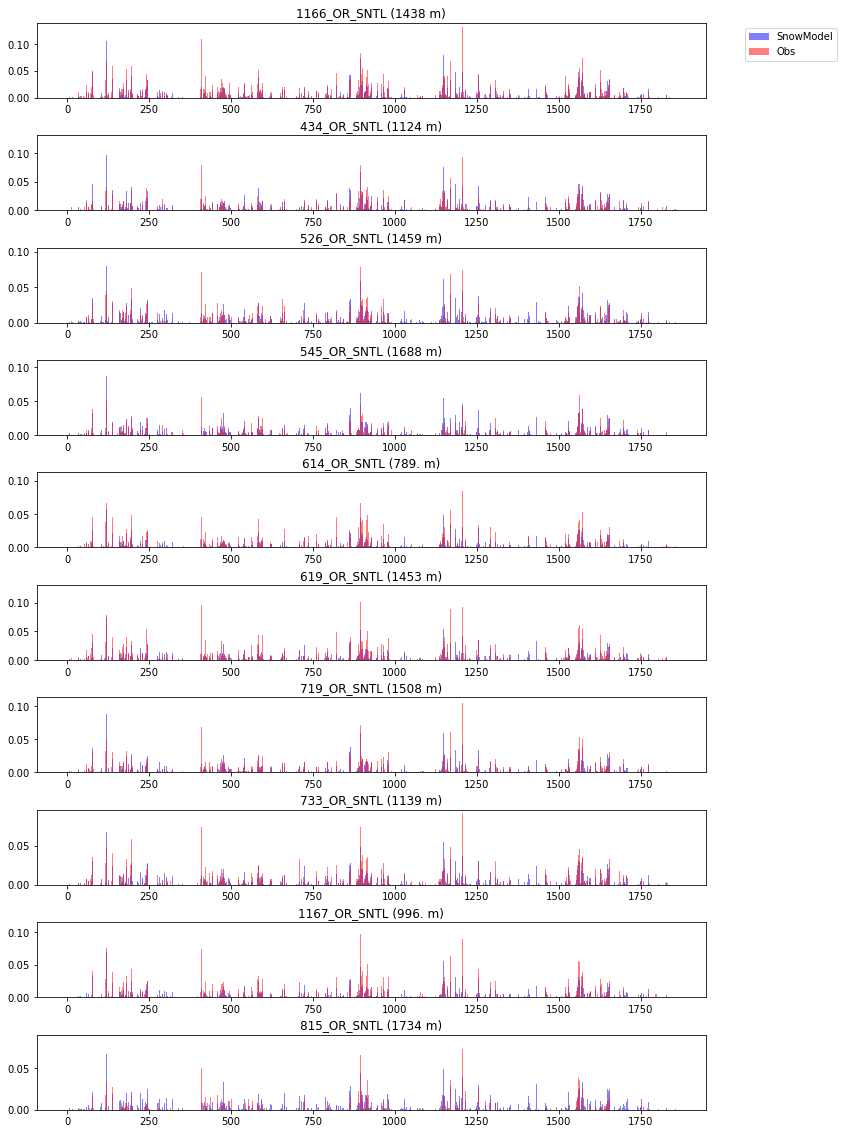

In [117]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'

domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']

# load the precip data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_PRmeters'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_pr=dftemp.set_index(dftemp.datetime,drop=True)
stn_pr

ctlFile = SMpath+'ctl_files/wo_assim/prec.ctl'
dset = open_CtlDataset(ctlFile)
#mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_pr[nam].values
    pt = (gdf.to_crs(domains[domain]['mod_proj']).geometry[i].x,gdf.to_crs(domains[domain]['mod_proj']).geometry[i].y)
    xval = np.where(np.abs(eas-pt[0]) == np.min(np.abs(eas-pt[0])))[0][0]
    yval = np.where(np.abs(nor-pt[1]) == np.min(np.abs(nor-pt[1])))[0][0]
    mod = dset.prec.sel(lon = xval,lat = yval).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].bar(np.arange(len(mod)),mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].bar(np.arange(len(obs)),obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

In [41]:
def nearest_grid(ds, pt):
    """
    Returns the nearest easting and norting to pt in a given Dataset (ds).
    
    pt : input point, tuple (easting, northing)
    output:
        lon, lat
    """
    if all(coord in list(ds.coords) for coord in ['lat', 'lon']):
            df_loc = ds[['lon', 'lat']].to_dataframe().reset_index()
    loc_valid = df_loc.dropna()
    pts = loc_valid[['lon', 'lat']].to_numpy()
    idx = distance.cdist([pt], pts).argmin()
    return loc_valid['lon'].iloc[idx], loc_valid['lat'].iloc[idx]

code   longitude   latitude                 name  \
0  1166_OR_SNTL -122.093803  44.325298           Bear Grass   
1   434_OR_SNTL -122.087181  44.521469            Daly Lake   
2   526_OR_SNTL -121.856552  44.420422            Hogg Pass   
3   545_OR_SNTL -121.947929  43.803680         Irish Taylor   
4   614_OR_SNTL -121.973648  44.593971         Marion Forks   
5   619_OR_SNTL -121.872917  44.210300             Mckenzie   
6   719_OR_SNTL -122.030632  43.900982        Roaring River   
7   733_OR_SNTL -121.945023  44.435032         Santiam Jct.   
8  1167_OR_SNTL -122.040527  44.303249          Smith Ridge   
9   815_OR_SNTL -121.640953  44.144249  Three Creeks Meadow   

          elevation_m        easting      northing  \
0   1438.656005859375  572255.451212  4.908403e+06   
1  1124.7120361328125  572540.471215  4.930199e+06   
2   1459.991943359375  591025.222762  4.919206e+06   
3   1688.592041015625  584626.662707  4.850606e+06   
4   789.4320068359375  581461.571806  4.938360e+06   
5    1453.89599609375  590043.243451  4.895848e+06   
6   1508.760009765625  577847.500754  4.861332e+06   
7  1139.9520263671875  583961.512473  4.920734e+06   
8  996.69598388671875  576532.073321  4.906003e+06   
9    1734.31201171875  608696.366131  4.888792e+06   

                      geometry  
0  POINT (-122.09380 44.32530)  
1  POINT (-122.08718 44.52147)  
2  POINT (-121.85655 44.42042)  
3  POINT (-121.94793 43.80368)  
4  POINT (-121.97365 44.59397)  
5  POINT (-121.87292 44.21030)  
6  POINT (-122.03063 43.90098)  
7  POINT (-121.94502 44.43503)  
8  POINT (-122.04053 44.30325)  
9  POINT (-121.64095 44.14425)

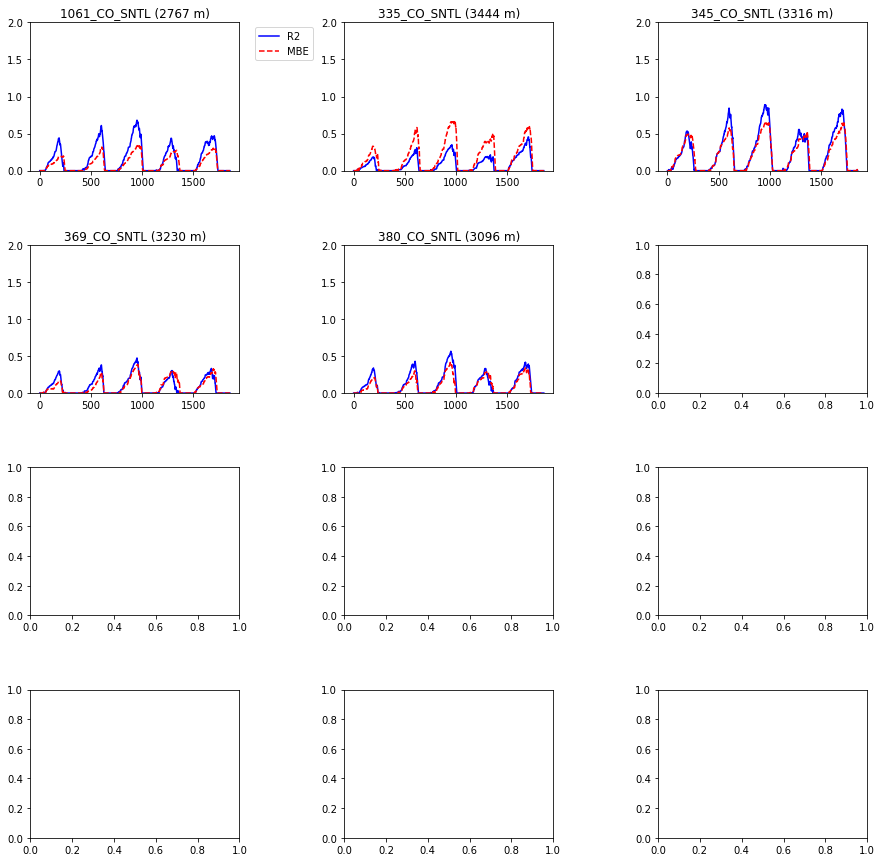

In [194]:
fig, axs = plt.subplots(nrows=4, figsize=(15, 15), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(5):#np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = dset.swed.sel(lon = dset.lon[i],lat = 1).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,c='b')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(['R2','MBE','RMSE','NSE', 'KGE','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

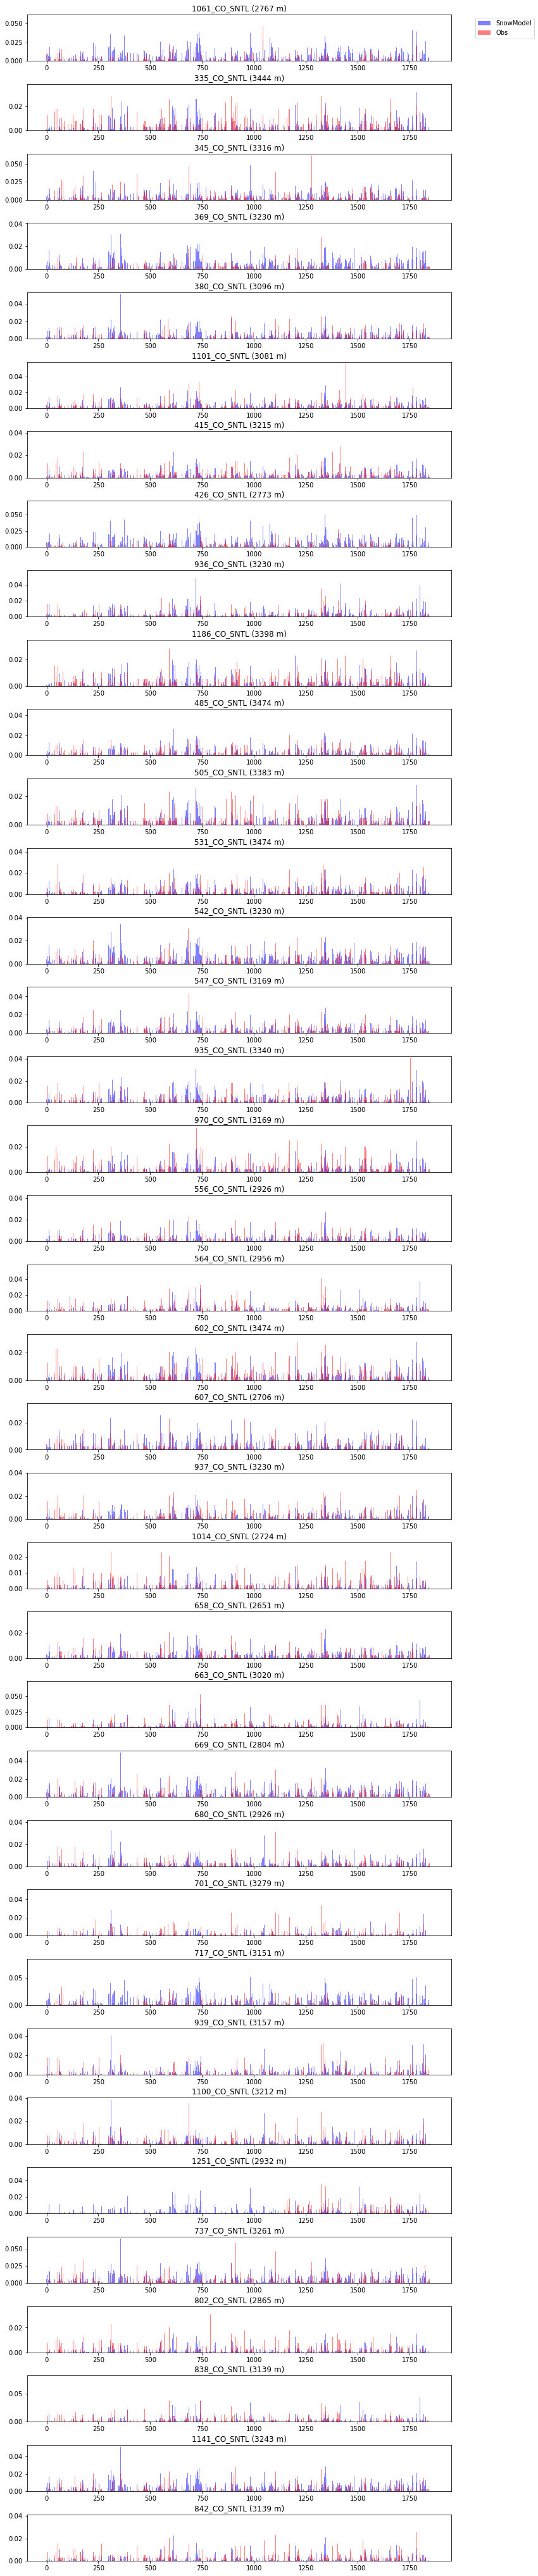

In [208]:
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'

domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']

# load the precip data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_PRmeters'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_pr=dftemp.set_index(dftemp.datetime,drop=True)
stn_pr

ctlFile = SMpath+'ctl_files/wo_assim/prec.ctl'
dset = open_CtlDataset(ctlFile)
#mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_pr[nam].values
    mod = dset.prec.sel(lon = dset.lon[i],lat = 1).diff('time').values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].bar(np.arange(len(mod)),mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].bar(np.arange(len(obs)),obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

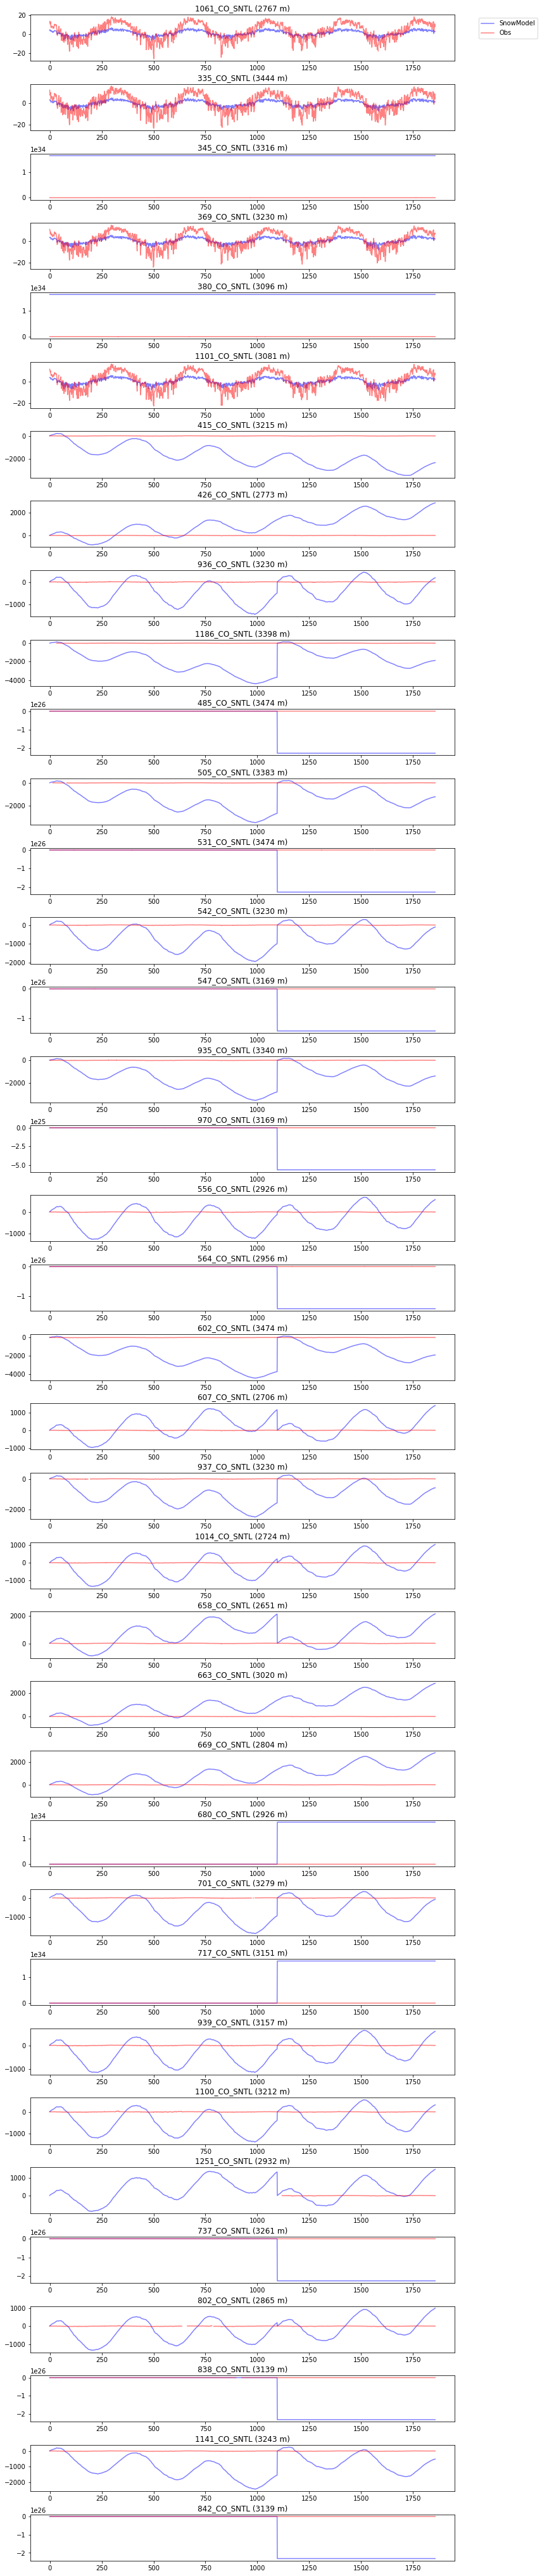

In [227]:
# load the temp data from snotel 
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_TAVGcelsius'+st_dt+'_'+ed_dt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_temp=dftemp.set_index(dftemp.datetime,drop=True)
stn_temp

ctlFile = SMpath+'ctl_files/wo_assim/tair.ctl'
dset = open_CtlDataset(ctlFile)
#mod_swe = get_mod_output_lines(sweFile)

elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(inswe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30) 
#CA: nrows=8,figsize=(15, 24) 
#OR: nrows=4, figsize=(15, 15)
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
#ID: nrows=3, figsize=(15, 10)
fig, axs = plt.subplots(nrows=len(gdf), figsize=(12, 2*len(gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    obs = stn_temp[nam].values
    mod = dset.tair.sel(lon = dset.lon[i],lat = 1).values
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    axs[i].plot(mod,color='b', label ='SnowModel',alpha = 0.5)
    axs[i].plot(obs,color='r',label ='Obs',alpha = 0.5)
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left',)